 Neovya - mapping & preprocessing

## Imports & chargement des données

In [1]:
import pandas as pd
import numpy as np
import descartes
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from shapely.geometry import Point, Polygon
import datetime
import statsmodels.api as sm 
import re

%matplotlib inline

In [2]:
df = pd.read_csv('/Users/hugo/neovya/Data/Bordeaux_sensordef.csv', sep=';')
df_timeseries = pd.read_csv('/Users/hugo/neovya/Data/Bordeaux_sensortimeseries.csv', sep=';')

# Mapping GPS coordonates

Nous utiliserons pour la visualisation des capteurs la librairie opensource GeoPandas (https://geopandas.org/).  
Nous utiliserons également OpenStreetMap pour obtenir des cartes


## pre processing

In [3]:
df.head()

sensor          source                     info  link  \
0  S_MB333.F_0  DIR Atlantique    ech3 - sens extérieur   364   
1  S_MB333.F_1  DIR Atlantique        ech3 - sens inter   198   
2  S_MB333.F_2  DIR Atlantique  ech3 - sortie extérieur    63   
3  S_MB333.E_0  DIR Atlantique        ech2 - sens exter    57   
4  S_MB333.E_1  DIR Atlantique        ech2 - sens inter   185   

   position_on_link_[m]        lat       lon  muted  
0            111.434103  44.879983 -0.525714   True  
1             60.419032  44.879869 -0.525645   True  
2            131.449616  44.879930 -0.525983   True  
3            146.433858  44.884118 -0.519036   True  
4            272.844830  44.884036 -0.518900   True

In [4]:
#Vérification et tri des données de latitude
df.lat.sort_values()

131    44.815794
132    44.815794
27     44.817650
28     44.817686
51     44.820721
         ...    
124    44.887974
121    44.888066
123    44.888121
127    44.936106
128    44.936122
Name: lat, Length: 133, dtype: float64

In [5]:
#Vérification et tri des données de longitude
df.lon.sort_values()

124   -0.583220
123   -0.583146
122   -0.582188
121   -0.582096
119   -0.575597
         ...   
47    -0.473696
130   -0.469238
127   -0.467415
128   -0.467200
129   -0.467172
Name: lon, Length: 133, dtype: float64

In [6]:
#Création d'un copie du df pour travailler le format de longitude et latitude
df_coordonate = df.copy()
#Initialisation du CRS permettant à Python de localiser des coordonnées GPS (lat & lon)
crs = {'init': 'epsg:4326'}
#Vérification du jeu de données
df_coordonate.head()

sensor          source                     info  link  \
0  S_MB333.F_0  DIR Atlantique    ech3 - sens extérieur   364   
1  S_MB333.F_1  DIR Atlantique        ech3 - sens inter   198   
2  S_MB333.F_2  DIR Atlantique  ech3 - sortie extérieur    63   
3  S_MB333.E_0  DIR Atlantique        ech2 - sens exter    57   
4  S_MB333.E_1  DIR Atlantique        ech2 - sens inter   185   

   position_on_link_[m]        lat       lon  muted  
0            111.434103  44.879983 -0.525714   True  
1             60.419032  44.879869 -0.525645   True  
2            131.449616  44.879930 -0.525983   True  
3            146.433858  44.884118 -0.519036   True  
4            272.844830  44.884036 -0.518900   True

Deux valeurs sont extrèmes et empèchent une bonne visualisation dans les prochaines étapes.  
Supprimons les pour le moment

In [7]:
#Localisation des lignes à supprimer
df_coordonate.loc[df_coordonate['lat']>44.9]

sensor source               info  link  position_on_link_[m]  \
127  LAPI L21  ALYCE  A10 vers Bordeaux   239             33.801291   
128  LAPI L22  ALYCE     A10 vers Paris   332            830.775255   

           lat       lon  muted  
127  44.936106 -0.467415  False  
128  44.936122 -0.467200  False

In [8]:
#Suppression des deux lignes
#Attention, ces données seront peut-être à reintégrer plus tard
df_coordonate_clean = df_coordonate.drop([128,127])

In [9]:
#Creation de Points pour décrire la latitude et longitude
geometry = [Point(xy) for xy in zip(df_coordonate_clean['lat'], df_coordonate_clean['lon'])]

Initialisation d'un GeoDataFrame nous permettant de créer une colonne "geometry" au format GeoSeries. 

In [10]:
#Création du GeoDataFrame
geo_df = gpd.GeoDataFrame(df_coordonate_clean, #Specifiy data
                          crs = crs, #specify our coordinate reference system
                          geometry = geometry)#specify the geometry list we created
geo_df.head()

/Applications/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


sensor          source                     info  link  \
0  S_MB333.F_0  DIR Atlantique    ech3 - sens extérieur   364   
1  S_MB333.F_1  DIR Atlantique        ech3 - sens inter   198   
2  S_MB333.F_2  DIR Atlantique  ech3 - sortie extérieur    63   
3  S_MB333.E_0  DIR Atlantique        ech2 - sens exter    57   
4  S_MB333.E_1  DIR Atlantique        ech2 - sens inter   185   

   position_on_link_[m]        lat       lon  muted                   geometry  
0            111.434103  44.879983 -0.525714   True  POINT (44.87998 -0.52571)  
1             60.419032  44.879869 -0.525645   True  POINT (44.87987 -0.52564)  
2            131.449616  44.879930 -0.525983   True  POINT (44.87993 -0.52598)  
3            146.433858  44.884118 -0.519036   True  POINT (44.88412 -0.51904)  
4            272.844830  44.884036 -0.518900   True  POINT (44.88404 -0.51890)

# Visualisation

L'objectif ici est de visualiser l'ensemble des capteurs puis de sélectionner ceux étant sur la route N230. Nous souhaitons sélectionner cette route car c'est celle regroupant le plus de capteurs, espacés de façon équilibré.

Map data (c) OpenStreetMap contributors, https://www.openstreetmap.org  
Extracts created by BBBike, https://extract.bbbike.org

In [11]:
#Ouverture du fichier contenant la carte
rocade = gpd.read_file ('/Users/hugo/neovya/Data/planet-shp/shape/roads.shp')
#Création du geodataframe utilisé pour créer la carte
gdf = gpd.GeoDataFrame(geo_df, geometry=gpd.points_from_xy(df_coordonate_clean.lon, df_coordonate_clean.lat))

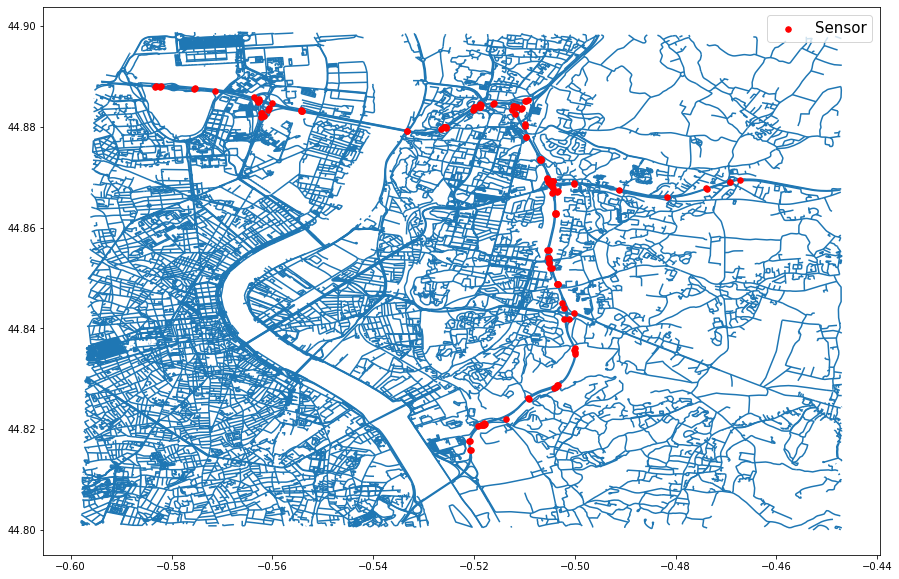

In [12]:
#Plot de la position des capteurs
ax = rocade.plot(figsize= (15,15))

gdf.plot (ax=ax,  markersize = 30, color="red", zorder = 2, label = "Sensor")
plt.legend(prop={'size': 15})
plt.show()

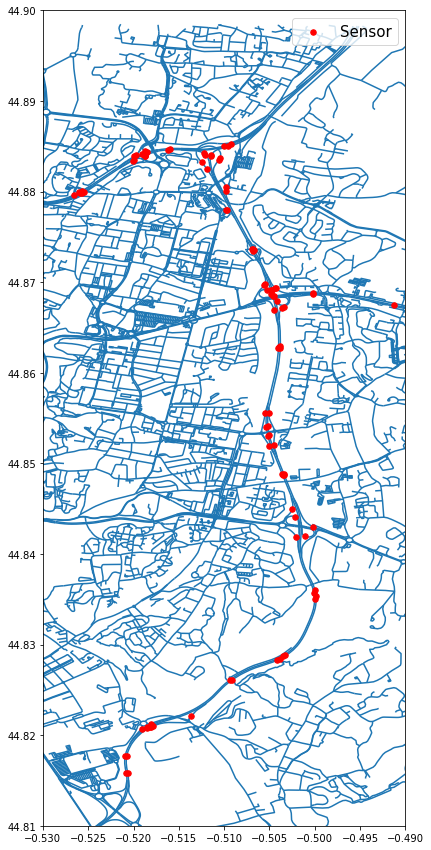

In [13]:
#Zoom sur la N230
ax = rocade.plot(figsize= (15,15))

gdf.plot (ax=ax,  markersize = 30, color="red", zorder = 2, label = "Sensor")
plt.legend(prop={'size': 15})
plt.axis([-0.53,-0.49,44.81,44.9])
plt.show()

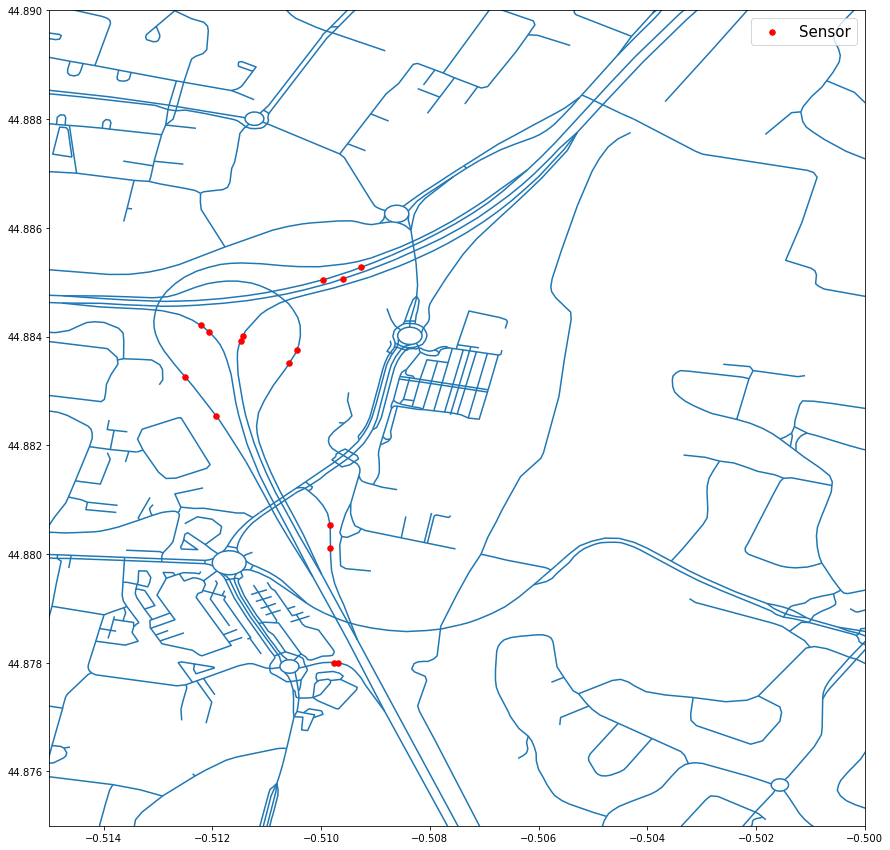

In [14]:
#Zoom pour visualiser les positions exactes des capteurs autour de la N230
ax = rocade.plot(figsize= (15,15))

gdf.plot (ax=ax,  markersize = 30, color="red", zorder = 2, label = "Sensor")
plt.legend(prop={'size': 15})
plt.axis([-0.515,-0.5,44.875,44.89])
plt.show()

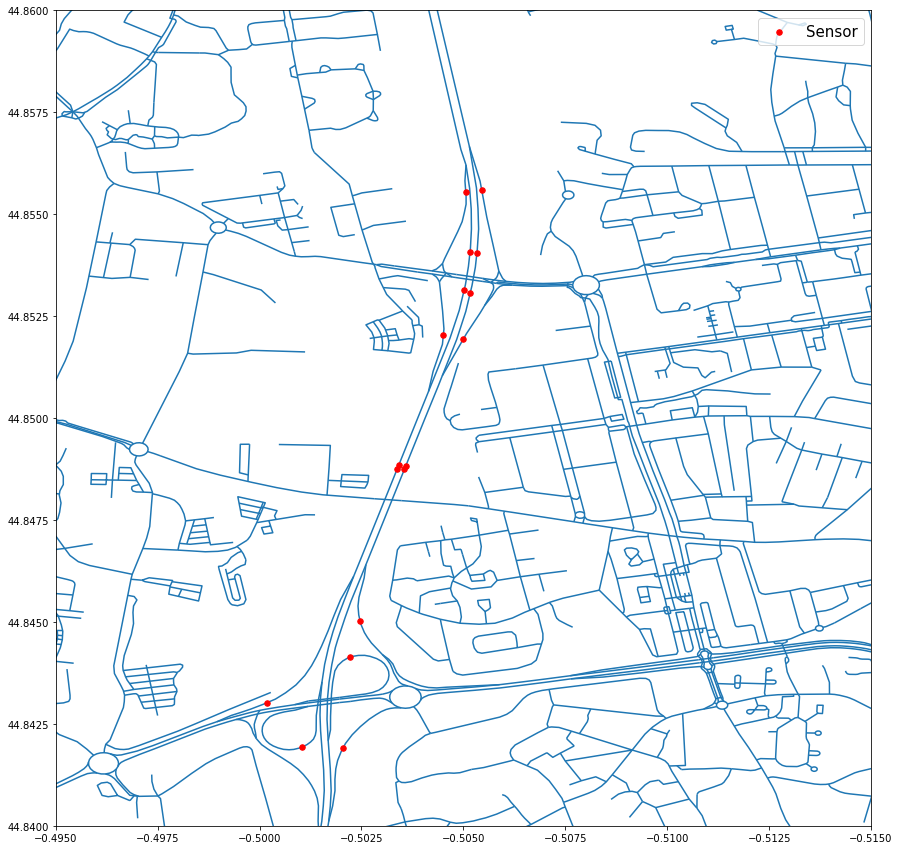

In [15]:
#Zoom pour visualiser les positions exactes des capteurs autour de la N230
ax = rocade.plot(figsize= (15,15))

gdf.plot (ax=ax,  markersize = 30, color="red", zorder = 2, label = "Sensor")
plt.legend(prop={'size': 15})
plt.axis([-0.495,-0.515,44.84,44.86])
plt.show()

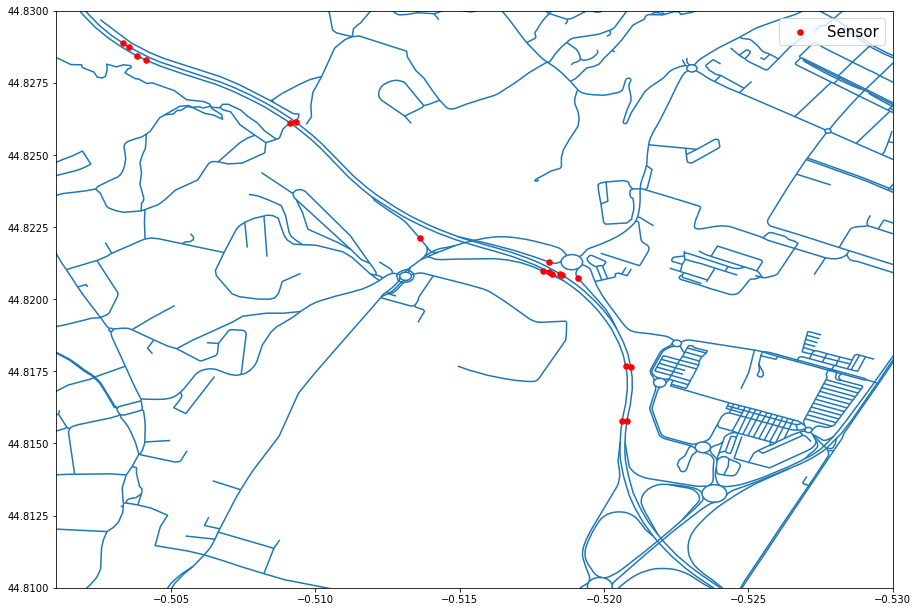

In [16]:
#Zoom pour visualiser les positions exactes des capteurs autour de la N230
ax = rocade.plot(figsize= (15,15))

gdf.plot (ax=ax,  markersize = 30, color="red", zorder = 2, label = "Sensor")
plt.legend(prop={'size': 15})
plt.axis([-0.501,-0.53,44.81,44.83])
plt.show()

Interprétation: Grace à cette visualisation, nous allons pouvoir séléctionner uniquement les capteurs se trouvant sur la route N230. Ce choix de se focaliser sur cette route provient de conseils d'Aurélien Duret. La N230 est la route regroupant le plus de capteurs du jeu de données, ils sont également espacés de façon relativement simillaires.   
Nous allons commencer notre analyse en sélectionnant un ou deux capteurs. Pour sélectionner ces capteurs, il fallait dans un premier temps localiser l'ensemble des capteurs de la N230 pour ensuite sélectionner à l'interieur de cette liste.

# Recherche des sensors qui sont sur la route verticale (N230):


La route N230 s'étend dans cette plage de coordonnés, ces valeurs ont été trouvées grâce au travail de visualisation de l'étape précédente:

Latitude: 44.89 à 41.815  
Longitude: -0.495 à -0.522

## Etape 1: Suppression des sensors loins de la N230:

In [17]:
#Création d'un nouveau regroupant uniquement les sensors proches de la N230
df_n230 = df_coordonate_clean.loc[(df_coordonate_clean['lat']>= 41.815) & (df_coordonate_clean['lat']<=44.89) & (df_coordonate_clean['lon']>= -0.522) & (df_coordonate_clean['lon']<= -0.495)]

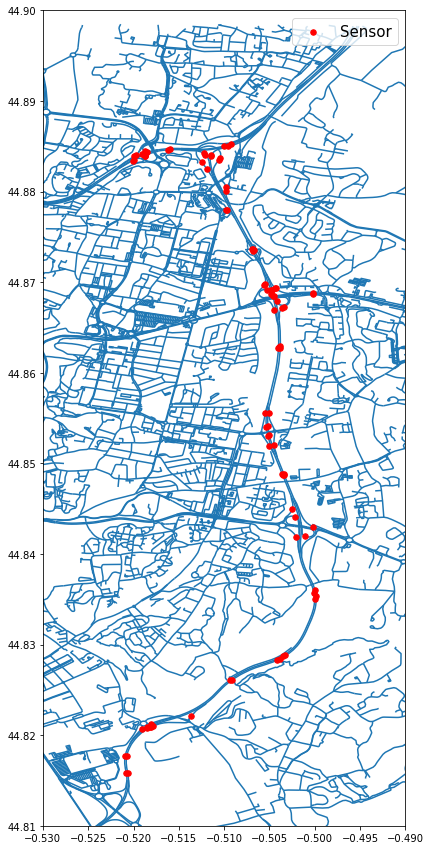

In [18]:
#Visualisation des capteurs sélectionnés:

gdf = gpd.GeoDataFrame(df_n230, geometry=gpd.points_from_xy(df_n230.lon, df_n230.lat))

ax = rocade.plot(figsize= (15,15))

gdf.plot (ax=ax,  markersize = 30, color="red", zorder = 2, label = "Sensor")
plt.legend(prop={'size': 15})
plt.axis([-0.53,-0.49,44.81,44.9])
plt.show()

## Etape 2: Suppression des capteurs proches de la N230 restants (en haut à gauche de la map):

Après une analyse visuelle de la carte:  
Les points compris dans ces intervals sont à supprimer:  44.88 < lat < 44.89 & - 0.525 < long < - 0.515    

In [19]:
#Recherche des sensors compris dans l'interval
todrop = df_n230.loc[(df_n230['lat']>= 44.88) & (df_n230['lat']<=44.89) & (df_n230['lon']>= -0.525) & (df_n230['lon']<= -0.515)] #Liste des points à supprimer
idxtodrop = todrop.index #Index des points à supprimer
idxtodrop


Int64Index([3, 4, 5, 6, 7, 8, 24, 25, 96, 97, 98, 99, 100, 101], dtype='int64')

In [20]:
#Suppression des points:
df_n230 = df_n230.drop(idxtodrop)

## Etape 3: Suppression des capteurs proches de la N230 restants (en haut à droite de la map):

Après une analyse visuelle de la carte, il reste encore des points à supprimer:  
Les points compris dans ces intervals sont à supprimer:  44.88 < lat < 44.89 & long < - 0.511   

In [21]:
#Recherche des sensors compris dans l'interval
todrop = df_n230.loc[(df_n230['lat']>= 44.885) & (df_n230['lat']<=44.89) & (df_n230['lon']>= -0.511)] #Liste des points à supprimer
idxtodrop = todrop.index #Index des points à supprimer
idxtodrop

Int64Index([26, 94, 95], dtype='int64')

In [22]:
#Suppression des points:
df_n230 = df_n230.drop(idxtodrop)

## Etape 3: Suppression du dernier sensor proche de la N230 restant (route perpendiculaire à droite):

Après une analyse visuelle de la carte, il reste encore un point à supprimer:  
Le point compris dans ces intervals est à supprimer:  44.86 < lat < 44.87 & long < - 0.502   

In [23]:
#Recherche du sensor compris dans l'interval
todrop = df_n230.loc[(df_n230['lat']>= 44.86) & (df_n230['lat']<=44.87) & (df_n230['lon']>= -0.502)] #Liste des points à supprimer
idxtodrop = todrop.index #Index des points à supprimer
idxtodrop

Int64Index([22, 23], dtype='int64')

In [24]:
#Suppression des points:
df_n230 = df_n230.drop(idxtodrop)

In [25]:
#Création du geodataframe utilisé pour créer la carte
gdf = gpd.GeoDataFrame(df_n230, geometry=gpd.points_from_xy(df_n230.lon, df_n230.lat))

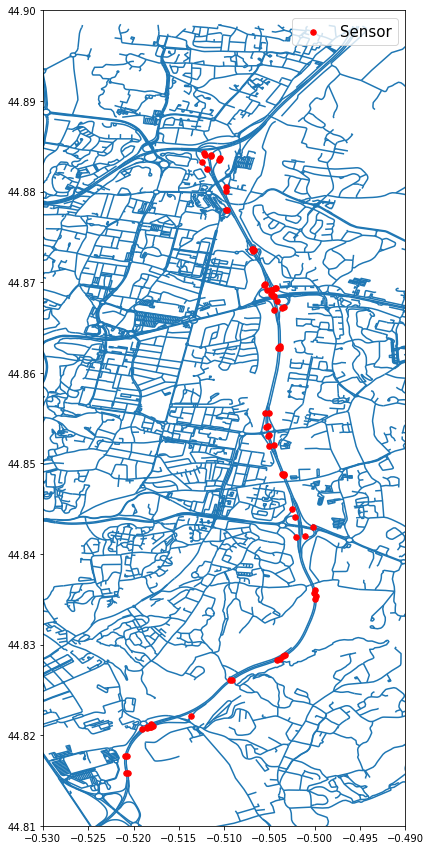

In [26]:
#Vérification: 
ax = rocade.plot(figsize= (15,15))

gdf.plot (ax=ax,  markersize = 30, color="red", zorder = 2, label = "Sensor")
plt.legend(prop={'size': 15})
plt.axis([-0.53,-0.49,44.81,44.9])
plt.show()


## Conlusion:

In [27]:
df_n230

sensor          source                                       info  \
14   S_MBG33.n_0  DIR Atlantique                         ech25 - sens exter   
15   S_MBG33.n_1  DIR Atlantique                         ech25 - sens inter   
16   S_MB333.e_0  DIR Atlantique   ech26 - sens exter (position à vérifier)   
17   S_MB333.e_1  DIR Atlantique  ech26 - sens inter (vérifier la position)   
18   S_MB333.e_2  DIR Atlantique                       ech26 - sortie exter   
..           ...             ...                                        ...   
91     5146.11 1  DIR Atlantique                                       Ech1   
92     5146.10 2  DIR Atlantique                                       Ech1   
93     5146.12 2  DIR Atlantique                                       Ech1   
131     LAPI L41           ALYCE                           Rocade vers Nord   
132     LAPI L42           ALYCE                            Rocade vers sud   

     link  position_on_link_[m]        lat       lon  muted  \
14    313            389.340062  44.854073 -0.505162   True   
15    383            292.630511  44.854040 -0.505330   True   
16    371             44.892246  44.869160 -0.504681   True   
17    387            271.333367  44.869137 -0.504850   True   
18    234             51.401003  44.867143 -0.503572   True   
..    ...                   ...        ...       ...    ...   
91    178            124.531901  44.883925 -0.511477  False   
92    221             81.406975  44.884092 -0.512069  False   
93    191            375.687831  44.883251 -0.512496  False   
131   319             76.558151  44.815794 -0.520793  False   
132   377            370.906326  44.815794 -0.520626  False   

                      geometry  
14   POINT (-0.50516 44.85407)  
15   POINT (-0.50533 44.85404)  
16   POINT (-0.50468 44.86916)  
17   POINT (-0.50485 44.86914)  
18   POINT (-0.50357 44.86714)  
..                         ...  
91   POINT (-0.51148 44.88393)  
92   POINT (-0.51207 44.88409)  
93   POINT (-0.51250 44.88325)  
131  POINT (-0.52079 44.81579)  
132  POINT (-0.52063 44.81579)  

[73 rows x 9 columns]

On a maintenant df_n230 qui regroupe uniquement les sensors sur cette route ou très proche. Il y a 73 sensors.  
La prochaine étape est maintenant d'arriver à un jeu de données clean regroupant uniquement ces sensors sur la période avec le plus de mesure (septembre/octobre 2019).

In [28]:
#Exportons ce dataframe pour s'en servir comme data preprocessed:
df_n230.to_csv(r'/Users/hugo/neovya/Data/neovya_sensors_n230.csv')

# Cleaning & preprocessing

## Cleaning du fichier
L'objectif ici est de nettoyer au maximum le jeu de données pour par la suite faire une selection de capteurs

###  Garder uniquement les sensors de la route N230:#

In [29]:
#Listing des sensors présents sur la n230
sensors_list = df_n230['sensor']
sensors_list

14     S_MBG33.n_0
15     S_MBG33.n_1
16     S_MB333.e_0
17     S_MB333.e_1
18     S_MB333.e_2
          ...     
91       5146.11 1
92       5146.10 2
93       5146.12 2
131       LAPI L41
132       LAPI L42
Name: sensor, Length: 73, dtype: object

In [30]:
#Gardons dans notre jeu de données "timeseries" uniquement les sensors concernés:
df_timeseries = df_timeseries.loc[df_timeseries['sensor'].isin(sensors_list)]
df_timeseries.sensor.value_counts()

LAPI L42       7200
LAPI L41       7200
5044.10 2      6720
5143.01 2      6720
5044.13 1      6720
               ... 
S_MBG33.R_1    1416
S_MB333.M_1    1416
S_MBG33.N_0    1416
S_MB333.e_5    1416
S_MBG33.N_1    1415
Name: sensor, Length: 65, dtype: int64

Nous avons 65 capteurs présents dans le jeu de données timeseries qui se trouvent sur la N230.

###  Simplification des colonnes

In [31]:
df_timeseries.columns

Index(['day', 'sensor', 'time_[s]', 'speed_[km/h]', 'occupancy_[%]', 'TV/h',
       'PL/h', 'VL/h', 'speed_per_lane', 'occupancy_per_lane',
       'flow_per_lane_[veh/h]'],
      dtype='object')

In [32]:
#Rename des colonnes pour simplification
df_timeseries = df_timeseries.rename(columns = {"speed_[km/h]": "speed", 'occupancy_[%]':'occupancy','time_[s]':"time"})

In [33]:
#Remplacement des vides de la colonne TV/h en faisant la somme de VL + PL
df_timeseries['TV/h'].fillna(df_timeseries['VL/h'] + df_timeseries['PL/h'], inplace = True)

In [34]:
#Fonction pour convertir les secondes en heure
def convert_second (df):
    df = float(df)
    return str(datetime.timedelta(seconds= df))

In [35]:
#Application de la fonction à la colonne
df_timeseries['time'] = df_timeseries['time'].apply(convert_second)

In [36]:
#Création d'une colonne contenant date + heure
df_timeseries['date'] = df_timeseries['day'] + " " + df_timeseries['time']
df_timeseries['date']

19824      01/09/2019 1:00:00
19825      01/09/2019 2:00:00
19826      01/09/2019 3:00:00
19827      01/09/2019 4:00:00
19828      01/09/2019 5:00:00
                 ...         
498306    20/10/2019 23:30:00
498307    20/10/2019 23:36:00
498308    20/10/2019 23:42:00
498309    20/10/2019 23:48:00
498310    20/10/2019 23:54:00
Name: date, Length: 289247, dtype: object

In [37]:
#Suppression des colonnes inutiles
df_timeseries = df_timeseries.drop(['speed_per_lane', 'occupancy_per_lane', 'flow_per_lane_[veh/h]', 'day','time'], axis=1, inplace=False)

In [38]:
#Modification de l'ordre des colonnes 
df_timeseries = df_timeseries[['sensor', 'date','VL/h','PL/h','TV/h','speed','occupancy']]

In [39]:
#Conversion de la date au format datetime
df_timeseries['date'] = pd.to_datetime(df_timeseries['date'],dayfirst = True)

In [40]:
#Ajout d'une colonne delta décrivant les intervals de temps entre les prises de mesure
df_timeseries['delta'] = df_timeseries['date'] - df_timeseries['date'].shift(1)

In [41]:
df_timeseries

sensor                date    VL/h   PL/h    TV/h  speed  \
19824   S_MBG33.n_0 2019-09-01 01:00:00  1557.0  126.0  1683.0    NaN   
19825   S_MBG33.n_0 2019-09-01 02:00:00  1239.0  106.0  1345.0    NaN   
19826   S_MBG33.n_0 2019-09-01 03:00:00   905.0   92.0   997.0    NaN   
19827   S_MBG33.n_0 2019-09-01 04:00:00   697.0   84.0   781.0    NaN   
19828   S_MBG33.n_0 2019-09-01 05:00:00   616.0   77.0   693.0    NaN   
...             ...                 ...     ...    ...     ...    ...   
498306     LAPI L42 2019-10-20 23:30:00   410.0  110.0   520.0   88.0   
498307     LAPI L42 2019-10-20 23:36:00   550.0  140.0   690.0   85.0   
498308     LAPI L42 2019-10-20 23:42:00   470.0  120.0   590.0   90.0   
498309     LAPI L42 2019-10-20 23:48:00   410.0  100.0   510.0   86.0   
498310     LAPI L42 2019-10-20 23:54:00   520.0  130.0   650.0   87.0   

        occupancy           delta  
19824         NaN             NaT  
19825         NaN 0 days 01:00:00  
19826         NaN 0 days 01:00:00  
19827         NaN 0 days 01:00:00  
19828         NaN 0 days 01:00:00  
...           ...             ...  
498306        NaN 0 days 00:06:00  
498307        NaN 0 days 00:06:00  
498308        NaN 0 days 00:06:00  
498309        NaN 0 days 00:06:00  
498310        NaN 0 days 00:06:00  

[289247 rows x 8 columns]

## Enrichissement du jeu de données

### Ajout de colonnes:
Ajout d'informations temporelles: 'add_date_part' & 'delta' 

In [42]:
def add_datepart(df, fldnames, drop=False, ignore_attr=['Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'], time=True, errors="raise"):	
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
	
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string or list of strings that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    ignore_attr: A list of attributes that are ignored during processing.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    >>>df2 = pd.DataFrame({'start_date' : pd.to_datetime(['3/11/2000','3/13/2000','3/15/2000']),
                            'end_date':pd.to_datetime(['3/17/2000','3/18/2000','4/1/2000'],infer_datetime_format=True)})
    >>>df2
        start_date	end_date    
    0	2000-03-11	2000-03-17
    1	2000-03-13	2000-03-18
    2	2000-03-15	2000-04-01
    >>>add_datepart(df2,['start_date','end_date'])
    >>>df2
    	start_Year	start_Month	start_Week	start_Day	start_Dayofweek	start_Dayofyear	start_Is_month_end	start_Is_month_start	start_Is_quarter_end	start_Is_quarter_start	start_Is_year_end	start_Is_year_start	start_Elapsed	end_Year	end_Month	end_Week	end_Day	end_Dayofweek	end_Dayofyear	end_Is_month_end	end_Is_month_start	end_Is_quarter_end	end_Is_quarter_start	end_Is_year_end	end_Is_year_start	end_Elapsed
    0	2000	    3	        10	        11	        5	            71	            False	            False	                False	                False	                False	            False	            952732800	    2000	    3	        11	        17	    4	            77	            False	            False	            False	            False	                False	        False	            953251200
    1	2000	    3	        11	        13	        0	            73	            False	            False	                False	                False               	False           	False           	952905600     	2000       	3	        11      	18  	5           	78          	False	            False           	False           	False               	False          	False           	953337600
    2	2000	    3	        11	        15	        2           	75          	False           	False               	False               	False               	False               False           	953078400      	2000    	4          	13      	1   	5           	92          	False           	True            	False           	True                	False          	False           	954547200
    """
    if isinstance(fldnames,str): 
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname] # fld = df['saledate']
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64

        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        targ_pre = re.sub('[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: 
            if n not in ignore_attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)

In [43]:
add_datepart(df_timeseries, "date")

<ipython-input-42-cb6212b455dd>:56: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if n not in ignore_attr: df[targ_pre + n] = getattr(fld.dt, n.lower())


In [44]:
df_timeseries

sensor                date    VL/h   PL/h    TV/h  speed  \
19824   S_MBG33.n_0 2019-09-01 01:00:00  1557.0  126.0  1683.0    NaN   
19825   S_MBG33.n_0 2019-09-01 02:00:00  1239.0  106.0  1345.0    NaN   
19826   S_MBG33.n_0 2019-09-01 03:00:00   905.0   92.0   997.0    NaN   
19827   S_MBG33.n_0 2019-09-01 04:00:00   697.0   84.0   781.0    NaN   
19828   S_MBG33.n_0 2019-09-01 05:00:00   616.0   77.0   693.0    NaN   
...             ...                 ...     ...    ...     ...    ...   
498306     LAPI L42 2019-10-20 23:30:00   410.0  110.0   520.0   88.0   
498307     LAPI L42 2019-10-20 23:36:00   550.0  140.0   690.0   85.0   
498308     LAPI L42 2019-10-20 23:42:00   470.0  120.0   590.0   90.0   
498309     LAPI L42 2019-10-20 23:48:00   410.0  100.0   510.0   86.0   
498310     LAPI L42 2019-10-20 23:54:00   520.0  130.0   650.0   87.0   

        occupancy           delta  Year  Month  Week  Day  Dayofweek  \
19824         NaN             NaT  2019      9    35    1          6   
19825         NaN 0 days 01:00:00  2019      9    35    1          6   
19826         NaN 0 days 01:00:00  2019      9    35    1          6   
19827         NaN 0 days 01:00:00  2019      9    35    1          6   
19828         NaN 0 days 01:00:00  2019      9    35    1          6   
...           ...             ...   ...    ...   ...  ...        ...   
498306        NaN 0 days 00:06:00  2019     10    42   20          6   
498307        NaN 0 days 00:06:00  2019     10    42   20          6   
498308        NaN 0 days 00:06:00  2019     10    42   20          6   
498309        NaN 0 days 00:06:00  2019     10    42   20          6   
498310        NaN 0 days 00:06:00  2019     10    42   20          6   

        Dayofyear  Hour  Minute  Second     Elapsed  
19824         244     1       0       0  1567299600  
19825         244     2       0       0  1567303200  
19826         244     3       0       0  1567306800  
19827         244     4       0       0  1567310400  
19828         244     5       0       0  1567314000  
...           ...   ...     ...     ...         ...  
498306        293    23      30       0  1571614200  
498307        293    23      36       0  1571614560  
498308        293    23      42       0  1571614920  
498309        293    23      48       0  1571615280  
498310        293    23      54       0  1571615640  

[289247 rows x 18 columns]

In [45]:
#Export du dataframe preprocessed pour reutilisation: 
df_timeseries.to_csv(r'/Users/hugo/neovya/Data/df_n230_clean.csv')

In [52]:
df_n230_clean = pd.read_csv('/Users/hugo/neovya/Data/df_n230_clean.csv')

In [53]:
df_n230_clean

Unnamed: 0       sensor                 date    VL/h   PL/h    TV/h  \
0            19824  S_MBG33.n_0  2019-09-01 01:00:00  1557.0  126.0  1683.0   
1            19825  S_MBG33.n_0  2019-09-01 02:00:00  1239.0  106.0  1345.0   
2            19826  S_MBG33.n_0  2019-09-01 03:00:00   905.0   92.0   997.0   
3            19827  S_MBG33.n_0  2019-09-01 04:00:00   697.0   84.0   781.0   
4            19828  S_MBG33.n_0  2019-09-01 05:00:00   616.0   77.0   693.0   
...            ...          ...                  ...     ...    ...     ...   
289242      498306     LAPI L42  2019-10-20 23:30:00   410.0  110.0   520.0   
289243      498307     LAPI L42  2019-10-20 23:36:00   550.0  140.0   690.0   
289244      498308     LAPI L42  2019-10-20 23:42:00   470.0  120.0   590.0   
289245      498309     LAPI L42  2019-10-20 23:48:00   410.0  100.0   510.0   
289246      498310     LAPI L42  2019-10-20 23:54:00   520.0  130.0   650.0   

        speed  occupancy            delta  Year  Month  Week  Day  Dayofweek  \
0         NaN        NaN              NaN  2019      9    35    1          6   
1         NaN        NaN  0 days 01:00:00  2019      9    35    1          6   
2         NaN        NaN  0 days 01:00:00  2019      9    35    1          6   
3         NaN        NaN  0 days 01:00:00  2019      9    35    1          6   
4         NaN        NaN  0 days 01:00:00  2019      9    35    1          6   
...       ...        ...              ...   ...    ...   ...  ...        ...   
289242   88.0        NaN  0 days 00:06:00  2019     10    42   20          6   
289243   85.0        NaN  0 days 00:06:00  2019     10    42   20          6   
289244   90.0        NaN  0 days 00:06:00  2019     10    42   20          6   
289245   86.0        NaN  0 days 00:06:00  2019     10    42   20          6   
289246   87.0        NaN  0 days 00:06:00  2019     10    42   20          6   

        Dayofyear  Hour  Minute  Second     Elapsed  
0             244     1       0       0  1567299600  
1             244     2       0       0  1567303200  
2             244     3       0       0  1567306800  
3             244     4       0       0  1567310400  
4             244     5       0       0  1567314000  
...           ...   ...     ...     ...         ...  
289242        293    23      30       0  1571614200  
289243        293    23      36       0  1571614560  
289244        293    23      42       0  1571614920  
289245        293    23      48       0  1571615280  
289246        293    23      54       0  1571615640  

[289247 rows x 19 columns]

In [54]:
#Suppression des colonnes inutiles
df_n230_clean = df_n230_clean.drop(['Unnamed: 0'], axis=1, inplace=False)

## Sélection de deux capteurs


L'objectif ici est de séléctionner deux capteurs pour commencer à travailler sur leurs données.  
Cette selection est nécessaire car les données n'ont pas le même format en fonction des capteurs.    
Nous avons donc décidé de selectionner dans un premier temps deux capteurs selon plusieurs critères: 
- Leurs présences sur la route N230
- Le nombre de données 
- La qualité des données (lignes/colonnes vides, nombre d'erreur)
- L'emplacement des capteurs   

En priorité, nous avons surtout besoin de capteurs ayant des données dans la colonne "speed". En effet, nous souhaitons prédire l'état du traffic en utilisant les données de vitesse. 

In [56]:
df_n230_clean.sensor.value_counts()

LAPI L42       7200
LAPI L41       7200
5044.10 2      6720
5143.01 2      6720
5044.13 1      6720
               ... 
S_MBG33.R_1    1416
S_MB333.M_1    1416
S_MBG33.N_0    1416
S_MB333.e_5    1416
S_MBG33.N_1    1415
Name: sensor, Length: 65, dtype: int64

Lapil41 & lapil42 ont la plus grande quantité de données

### Conversion au format datetime:

In [57]:
#Conversion au format datetime
df_n230_clean['date'] = pd.to_datetime(df_n230_clean['date'],dayfirst = True)

In [58]:
#Ajout des dates en index
df_time = df_n230_clean.set_index('date')

### Etude de la colonne "speed"

In [59]:
df_time['speed']

date
2019-09-01 01:00:00     NaN
2019-09-01 02:00:00     NaN
2019-09-01 03:00:00     NaN
2019-09-01 04:00:00     NaN
2019-09-01 05:00:00     NaN
                       ... 
2019-10-20 23:30:00    88.0
2019-10-20 23:36:00    85.0
2019-10-20 23:42:00    90.0
2019-10-20 23:48:00    86.0
2019-10-20 23:54:00    87.0
Name: speed, Length: 289247, dtype: float64

In [60]:
df_n230_speed = df_time.loc[df_time['speed'].notnull()]
df_n230_speed

sensor   VL/h   PL/h   TV/h  speed  occupancy  \
date                                                                    
2019-09-23 00:12:00  5442.00 2    NaN    NaN  490.0   88.0        NaN   
2019-09-23 00:18:00  5442.00 2    NaN    NaN  470.0   89.0        NaN   
2019-09-23 00:24:00  5442.00 2    NaN    NaN  420.0   86.0        NaN   
2019-09-23 00:30:00  5442.00 2    NaN    NaN  460.0   84.0        NaN   
2019-09-23 00:36:00  5442.00 2    NaN    NaN  330.0   83.0        NaN   
...                        ...    ...    ...    ...    ...        ...   
2019-10-20 23:30:00   LAPI L42  410.0  110.0  520.0   88.0        NaN   
2019-10-20 23:36:00   LAPI L42  550.0  140.0  690.0   85.0        NaN   
2019-10-20 23:42:00   LAPI L42  470.0  120.0  590.0   90.0        NaN   
2019-10-20 23:48:00   LAPI L42  410.0  100.0  510.0   86.0        NaN   
2019-10-20 23:54:00   LAPI L42  520.0  130.0  650.0   87.0        NaN   

                               delta  Year  Month  Week  Day  Dayofweek  \
date                                                                      
2019-09-23 00:12:00  0 days 00:06:00  2019      9    39   23          0   
2019-09-23 00:18:00  0 days 00:06:00  2019      9    39   23          0   
2019-09-23 00:24:00  0 days 00:06:00  2019      9    39   23          0   
2019-09-23 00:30:00  0 days 00:06:00  2019      9    39   23          0   
2019-09-23 00:36:00  0 days 00:06:00  2019      9    39   23          0   
...                              ...   ...    ...   ...  ...        ...   
2019-10-20 23:30:00  0 days 00:06:00  2019     10    42   20          6   
2019-10-20 23:36:00  0 days 00:06:00  2019     10    42   20          6   
2019-10-20 23:42:00  0 days 00:06:00  2019     10    42   20          6   
2019-10-20 23:48:00  0 days 00:06:00  2019     10    42   20          6   
2019-10-20 23:54:00  0 days 00:06:00  2019     10    42   20          6   

                     Dayofyear  Hour  Minute  Second     Elapsed  
date                                                              
2019-09-23 00:12:00        266     0      12       0  1569197520  
2019-09-23 00:18:00        266     0      18       0  1569197880  
2019-09-23 00:24:00        266     0      24       0  1569198240  
2019-09-23 00:30:00        266     0      30       0  1569198600  
2019-09-23 00:36:00        266     0      36       0  1569198960  
...                        ...   ...     ...     ...         ...  
2019-10-20 23:30:00        293    23      30       0  1571614200  
2019-10-20 23:36:00        293    23      36       0  1571614560  
2019-10-20 23:42:00        293    23      42       0  1571614920  
2019-10-20 23:48:00        293    23      48       0  1571615280  
2019-10-20 23:54:00        293    23      54       0  1571615640  

[160062 rows x 17 columns]

160 000 lignes sur 290 000 lignes ont la colonne "speed" complête

### Selection et test du LAPIL42

In [61]:
df_lapil42 = df_n230_speed.loc[df_n230_speed['sensor'] == 'LAPI L42']

In [62]:
def number_of_nan(df):
    dict = {}
    NaNs = 0
    for col in df.columns:
        if np.NaN in df[col].value_counts(dropna = False):
            NaNs = df[col][df[col].isnull()]
            dict[col] = len(NaNs)
    if type(NaNs) != int:
        for key, value in dict.items():
            print('Il y a {} valeurs nulles dans la colonne {}'.format(value, key))
    else: 
       print('aucune valeur nulle dans le DataFrame')

In [63]:
number_of_nan(df_lapil42)

Il y a 6720 valeurs nulles dans la colonne occupancy


In [64]:
#Suppression des colonnes inutiles
df_lapil42 = df_lapil42.drop(['occupancy'], axis=1, inplace=False)

#### Visualisation du nombre de véhicule total en fonction du temps

<AxesSubplot:xlabel='date'>

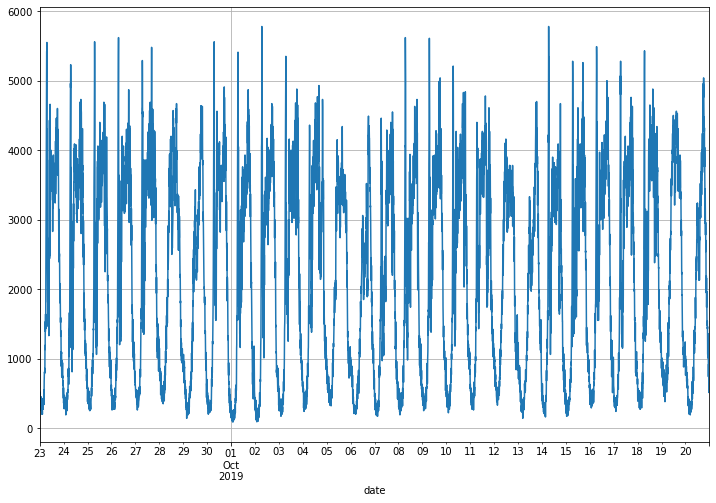

In [68]:
from datetime import datetime
#Regardons l'évolution du nombre total de véhicules sur deux mois
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
start_date = datetime (2019, 9, 1)
end_date = datetime (2019, 10, 31 )
df_lapil42['TV/h'][(start_date <=df_lapil42.index) & (df_lapil42.index <= end_date)].plot(grid=True)

<AxesSubplot:xlabel='date'>

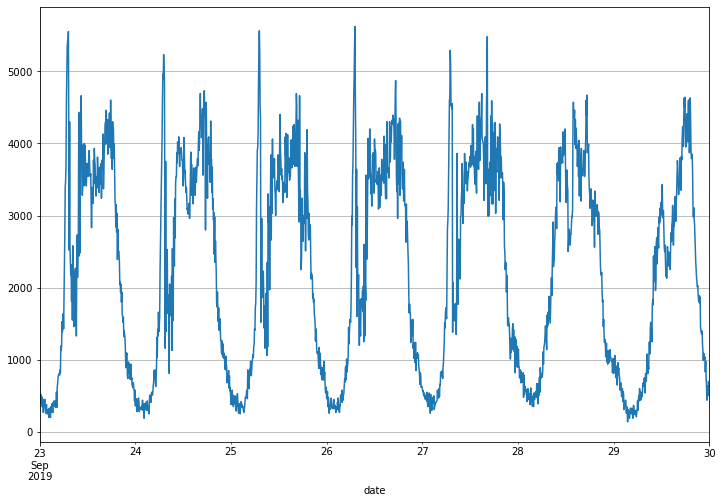

In [69]:
#Regardons l'évolution du nombre total de véhicules sur une semaine
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
start_date = datetime (2019, 9, 23)
end_date = datetime (2019, 9, 30 )
df_lapil42['TV/h'][(start_date <=df_lapil42.index) & (df_lapil42.index <= end_date)].plot(grid=True)

<AxesSubplot:xlabel='date'>

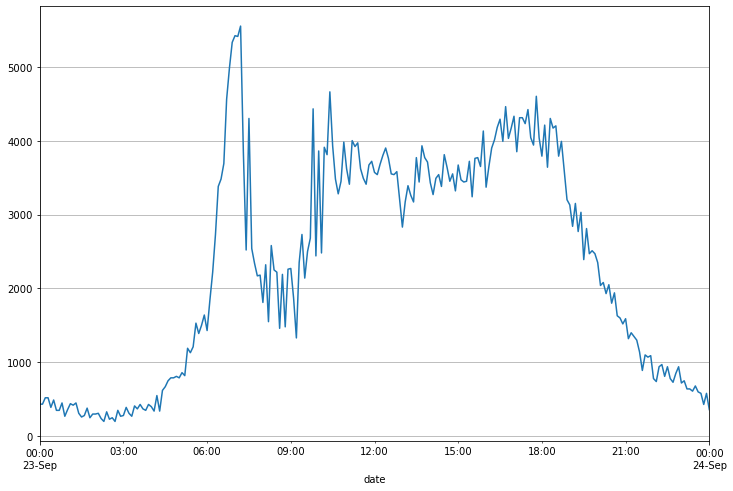

In [70]:
#Regardons l'évolution du nombre total de véhicules sur une journée
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
start_date = datetime (2019, 9, 23)
end_date = datetime (2019, 9, 24)
df_lapil42['TV/h'][(start_date <=df_lapil42.index) & (df_lapil42.index <= end_date)].plot(grid=True)

#### Visualisation de la vitesse en fonction du temps

<AxesSubplot:xlabel='date'>

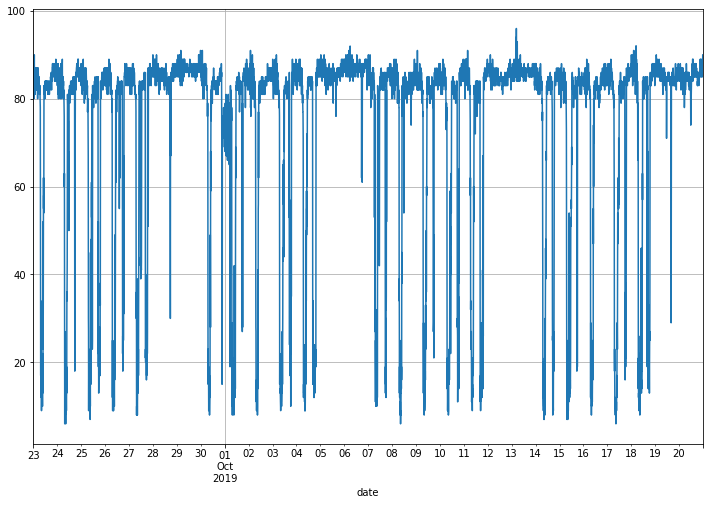

In [75]:
from datetime import datetime
#Regardons l'évolution de la vitesse sur deux mois
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
start_date = datetime (2019, 9, 1)
end_date = datetime (2019, 10, 31 )
df_lapil42['speed'][(start_date <=df_lapil42.index) & (df_lapil42.index <= end_date)].plot(grid=True)

<AxesSubplot:xlabel='date'>

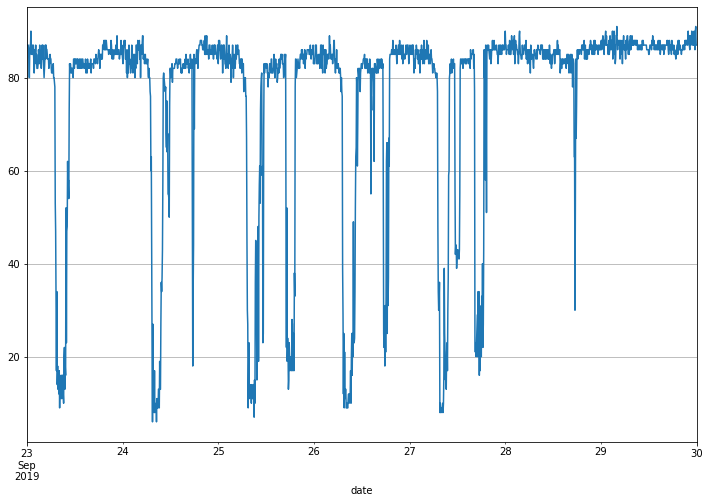

In [76]:
#Regardons l'évolution de la vitesse sur une semaine
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
start_date = datetime (2019, 9, 23)
end_date = datetime (2019, 9, 30 )
df_lapil42['speed'][(start_date <=df_lapil42.index) & (df_lapil42.index <= end_date)].plot(grid=True)

<AxesSubplot:xlabel='date'>

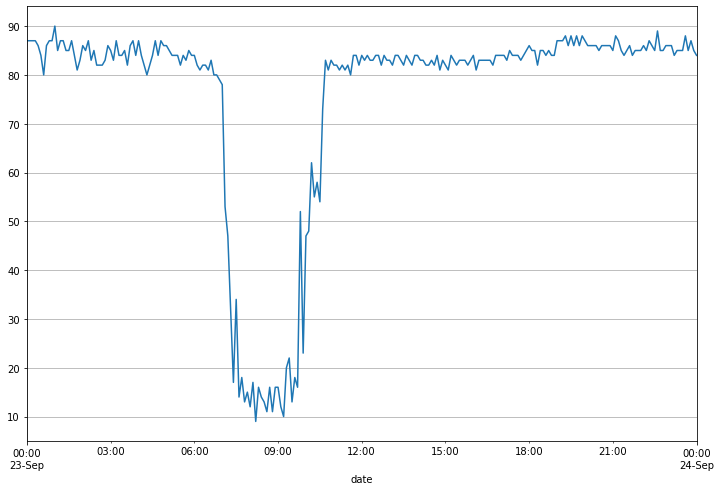

In [88]:
#Regardons l'évolution de la vitesse sur une journée
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
start_date = datetime (2019, 9, 23)
end_date = datetime (2019, 9, 24)
df_lapil42['speed'][(start_date <=df_lapil42.index) & (df_lapil42.index <= end_date)].plot(grid=True)

### Selection et test du LAPIL41

In [78]:
df_lapil41 = df_n230_speed.loc[df_n230_speed['sensor'] == 'LAPI L41']

In [79]:
number_of_nan(df_lapil41)

Il y a 6720 valeurs nulles dans la colonne occupancy


In [80]:
#Suppression des colonnes inutiles
df_lapil41 = df_lapil41.drop(['occupancy'], axis=1, inplace=False)

#### Visualisation du nombre de véhicule total en fonction du temps

<AxesSubplot:xlabel='date'>

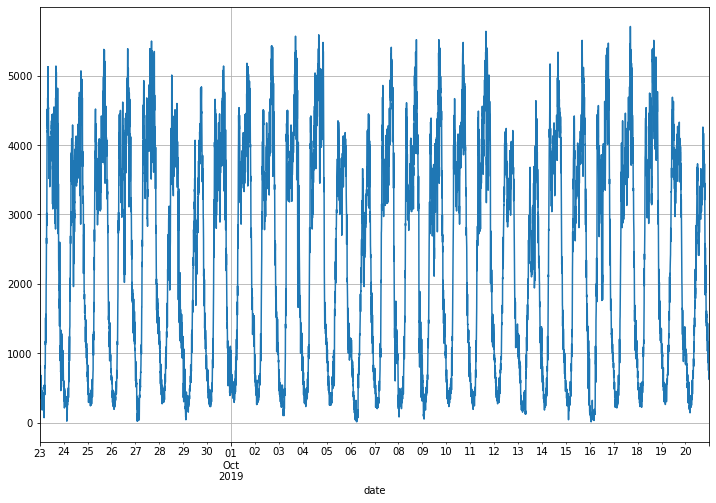

In [82]:
from datetime import datetime
#Regardons l'évolution du nombre total de véhicules sur deux mois
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
start_date = datetime (2019, 9, 1)
end_date = datetime (2019, 10, 31 )
df_lapil41['TV/h'][(start_date <=df_lapil41.index) & (df_lapil41.index <= end_date)].plot(grid=True)

<AxesSubplot:xlabel='date'>

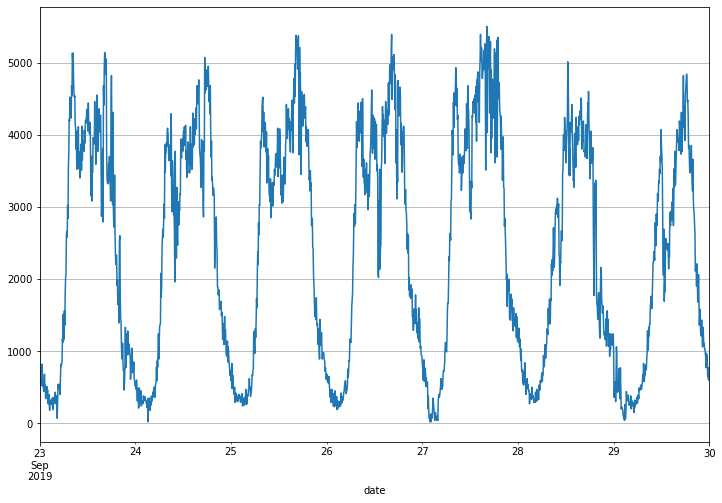

In [83]:
#Regardons l'évolution du nombre total de véhicules sur une semaine
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
start_date = datetime (2019, 9, 23)
end_date = datetime (2019, 9, 30 )
df_lapil41['TV/h'][(start_date <=df_lapil41.index) & (df_lapil41.index <= end_date)].plot(grid=True)

<AxesSubplot:xlabel='date'>

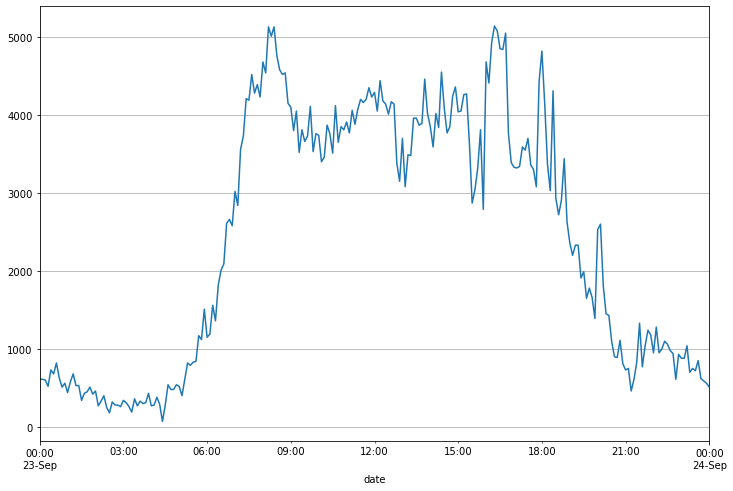

In [84]:
#Regardons l'évolution du nombre total de véhicules sur une journée
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
start_date = datetime (2019, 9, 23)
end_date = datetime (2019, 9, 24)
df_lapil41['TV/h'][(start_date <=df_lapil41.index) & (df_lapil41.index <= end_date)].plot(grid=True)

#### Visualisation de la vitesse en fonction du temps

<AxesSubplot:xlabel='date'>

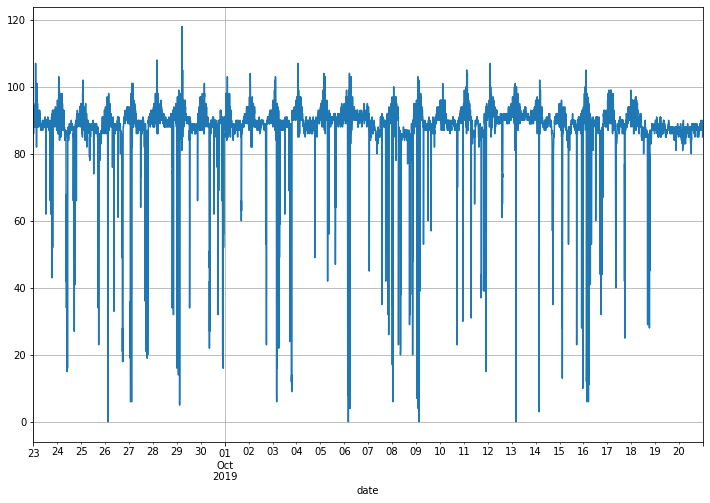

In [85]:
from datetime import datetime
#Regardons l'évolution de la vitesse sur deux mois
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
start_date = datetime (2019, 9, 1)
end_date = datetime (2019, 10, 31 )
df_lapil41['speed'][(start_date <=df_lapil41.index) & (df_lapil41.index <= end_date)].plot(grid=True)

<AxesSubplot:xlabel='date'>

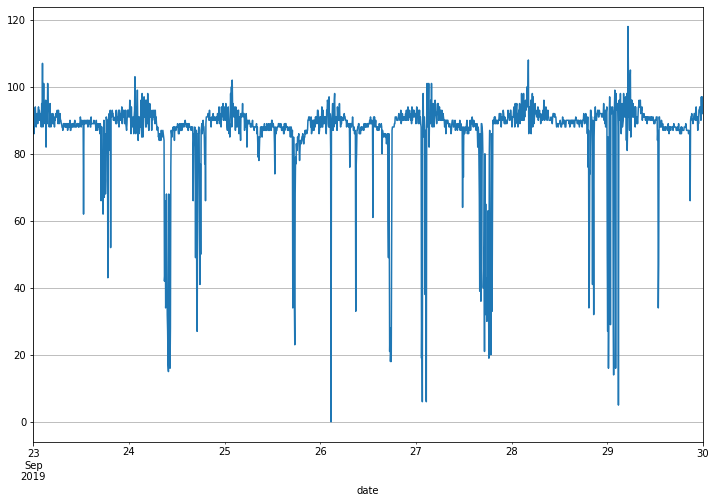

In [86]:
#Regardons l'évolution de la vitesse sur une semaine
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
start_date = datetime (2019, 9, 23)
end_date = datetime (2019, 9, 30 )
df_lapil41['speed'][(start_date <=df_lapil41.index) & (df_lapil41.index <= end_date)].plot(grid=True)

<AxesSubplot:xlabel='date'>

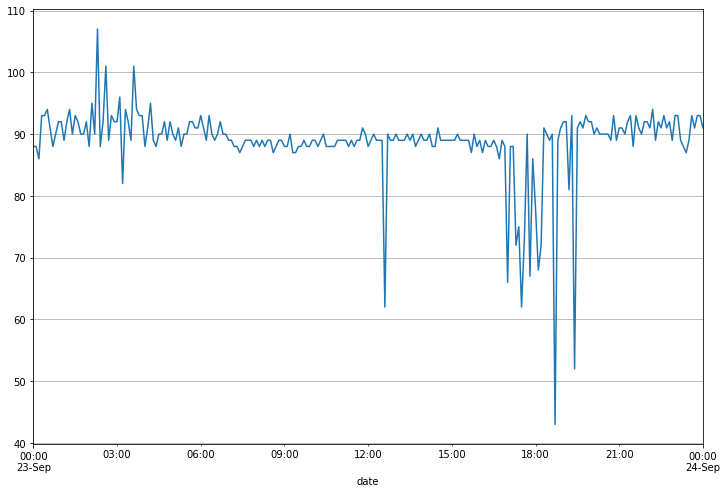

In [87]:
#Regardons l'évolution de la vitesse sur une journée
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
start_date = datetime (2019, 9, 23)
end_date = datetime (2019, 9, 24)
df_lapil41['speed'][(start_date <=df_lapil41.index) & (df_lapil41.index <= end_date)].plot(grid=True)

### Conclusion:   
Notre choix se porte sur les deux capteurs: Lapil42 & lapil41 car ils possèdent des données stables, sans vide, toutes les 6 minutes et ils sont également leus deux capteurs avec le plus de mesures. De plus, ils se situent à l'entrée de la N230, ce qui permettra de potentiellement créér des itinéraires à partir de ces capteurs par la suite.
